In [1]:
from piazza_api import Piazza
from functools import reduce
from os import environ
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Predicting students enrollment using FCE

### Table of Contents
* [Problem](#problem)
* Data
	* [Web Scraping](#web_scraping)
	* Pre-Processing
        * [Data Pre-processing](#preprocessing)
		* [Grouping](#grouping)
		* [Joining](#joining)
	* [Analysing](#describe)
* Visualizations   
    * [Interesting Patterns](#interesting)
* Features Engineering
    * [Techinical trends](#trends)
	* Type of Courses
		* [Registered Student](#size)
		* [Frequency](#frequency)
	* [Features Importance](#importance)
* Machine Learning    
    * [Prediction](#prediction)
    * [Implementation](#implementation)
* [Results](#results)
* [Conclusion](#conclusion)


<a id='problem'></a>
# Problem

Every semester hundreds of students try to find, the best courses to take. At the same time, they found the reality that they may not be able to enroll in all the courses they want due to quota limits.

We think the registration office may find useful a model which can help them to determine the number of students that will be registering for the following semester. This could help them to plan the number of sections, teachers and resources wanted, and how they could be best allocated.

To achieve this we plan on scraping the Faculty Student Evaluations (FCE) website, as a way of obtaining raw feedbacks from students. In addition, we will also analyze the current trend of technology and include the popularity of topics (e.g. Machine learning, computer vision, etc.) as a weighted feature. With these data, we aim to build a model that helps us predict the number of enrolling students in a course for a given semester.

<a id='web_scraping'></a>
# Web Scraping

We are using a browser driver instead of the request libraries, to be able to bypass CMU authentication.

In [2]:
import os
from time import sleep
# Scrapping Libraries
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [3]:
try:
    os.remove(r'data\table.csv')
except OSError:
    pass

# Change Chrome Download Directory to our repository
path = os.getcwd()
chromeOptions = webdriver.ChromeOptions()
prefs = {"download.default_directory" : r"%s\data" % path}
chromeOptions.add_experimental_option("prefs", prefs)

# Start chrome
chromedriver =r"%s\driver\chromedriver.exe" % path
driver = webdriver.Chrome(executable_path=chromedriver, chrome_options=chromeOptions)

df_raw = None

# -- Control chrome to authenticate with CMU and download the data --

# CMU Authentication
driver.get("https://login.cmu.edu/")

element = WebDriverWait(driver, 20).until(
    EC.presence_of_element_located((By.NAME, "j_username"))
)
u = driver.find_element_by_name('j_username')
u.send_keys(environ['CMU_USER'])

p = driver.find_element_by_name('j_password')
p.send_keys(environ['CMU_PWD'])
p.send_keys(Keys.RETURN)

# Give enouth time so that people with 2FA, can click OK in their phones
element = WebDriverWait(driver, 20).until(
    EC.presence_of_element_located((By.CLASS_NAME, "dataTable"))
)

# Authorize access to FCE
url = 'https://cmu.smartevals.com'
driver.get(url)

# Go to the results web page
url = 'https://wwwp3.smartevals.com/reporting/StudentsSeeResults.aspx'
driver.get(url)

# Download the data in CSV format
select = Select(driver.find_element_by_name('_ctl0:drpExport'))
select.select_by_visible_text('CSV')

In [4]:
# Load the data into a dataframe
file = './data/table.csv'
while not os.path.exists(file):
    sleep(5)
    # Computer takes some time to save to disk, after downloading the file

df_raw = pd.read_csv(file)
df_raw.shape

(44136, 23)

<a id='preprocessing'></a>
# Data Pre-processing

After scrapping the data, our fist question is, what of these values are incorrect or not helpful and should be removed from our dataset.

1- We will remove the data corresponding to the current semester, because these value are incomplete.

2- We will remove the data from years which have really sparse features. (Since we don't know which years this are, we will set this as parameter for now.

3- Courses which has only being offered 2 or less time. We need at least three data points to be able to see how the change in a feature affect the outocme.
  Ie. How the increase on work hours per week affect the number of enrolled students

4- Departments which no longer exists.

In [5]:
def clean(df, years=[2015, 2016,2017], verbose=True):
    N = 0
    
    # 1- Removes data from the current year
    df = df[df.Year != 2018]
    
    # 2- Only use data for the years we are insterested on
    df = df[df.Year.isin(years)]
    
    # 3- Remove courses offered less than 2 (or N) times
        
    # Count the number of times a course has been offered
    df_count = df.groupby(['Course ID'])['Semester'].count() 
    
    if verbose:
        for i in range(len(years)):
            N_1 = df_count[df_count == (i+1)].shape[0]
            print('# of courses teached %d time: %d' % (i+1, N_1))

    mask = (df_count[df_count >= len(years)]).index
    df_prune = df[df['Course ID'].isin(mask)]
    
    if verbose:
        N = df_prune.shape[0]
        print('- # of times offered -')
        print('# Removed Rows %d' % (df.shape[0]-N))
        print('# Remaining Rows %d' % (N))
    
    # 4- Departments that does not longer exist
    
    df_depts = df_prune[df_prune.Year == 2017]
    df_depts = df_depts.Dept.unique()
    df_prune = df_prune[df_prune.Dept.isin(df_depts)]
    
    # 4- Summer
    df_prune = df_prune[df_prune.Semester != 'Summer']

    # 5 - Removes courses without a teacher
    df_prune = df_prune[~df_prune.Name.isnull()]

    if verbose:
        prev_N = N
        N = df_prune.shape[0]
        print('- Non Existing Depts -')
        print('# Removed Rows %d' % (prev_N-N))
        print('# Remaining Rows %d' % (N))

    return df_prune

In [6]:
df_clean = clean(df_raw, years=range(2013, 2018))

# of courses teached 1 time: 1275
# of courses teached 2 time: 942
# of courses teached 3 time: 679
# of courses teached 4 time: 562
# of courses teached 5 time: 637
- # of times offered -
# Removed Rows 7444
# Remaining Rows 19482
- Non Existing Depts -
# Removed Rows 933
# Remaining Rows 18549


Our scrapped data has easily human readable column names, however these name are long and contain spaces, which makes it harder for programming puposes, thus we will rename this column using the below mapping

Data Mapping

'''
[('Year', 'year'),
 ('Semester', 'semester'),
 ('Dept', 'dept'),
 ('Course ID', 'num'),
 ('Section', 'section'),
 ('Name', 'prof'),
 ('Course Name', 'course_name'),
 ('Level', 'level'),
 ('Possible Respondents', 'students'),
 ('Num Respondents', 'answers'),
 ('Response Rate %', 'support'),
 ('Hrs Per Week', 'hrs_week'),
 ('Hrs Per Week 5', 'hrs_week_5'),
 ('Hrs Per Week 8', 'hrs_week_8'),
 ('Interest in student learning', 'prof_interest'),
 ('Clearly explain course requirements', 'course_requirements'),
 ('Clear learning objectives & goals', 'clear_goals'),
 ('Instructor provides feedback to students to improve', 'feedback'),
 ('Demonstrate importance of subject matter', 'subject_importance'),
 ('Explains subject matter of course', 'subject_matter'),
 ('Show respect for all students', 'respect'),
 ('Overall teaching rate', 'teaching_rate'),
 ('Overall course rate', 'course_rate')]
'''

In [7]:
def rename_columns(df, cols=None):
    if cols is None:
        df.columns = ['year', 'semester', 'dept', 'num', 'section', 'prof', 'course_name',
           'level', 'students', 'answers', 'support',
           'hrs_week', 'hrs_week_5', 'hrs_week_8',
           'prof_interest', 'course_requirements',
           'clear_goals',
           'feedback',
           'subject_importance',
           'subject_matter', 'respect',
           'teaching_rate', 'course_rate']
    else:
        df.columns = cols
    return df

df_clean = rename_columns(df_clean) 

It will also be useful to know from all the scrape features, which percentage of the data has the given feature. That way we can remove features, which have really small coverage.

In [8]:
def count_nulls(df):
    N = df.shape[0]
    nulls = df.isnull().sum(axis=0)
    results = (nulls/N).sort_values()
    return results
count_nulls(df_clean)

year                   0.000000
semester               0.000000
dept                   0.000000
num                    0.000000
section                0.000000
prof                   0.000000
course_name            0.000000
level                  0.000000
students               0.000000
answers                0.000000
support                0.000000
prof_interest          0.018815
clear_goals            0.019031
course_requirements    0.019085
course_rate            0.019085
teaching_rate          0.019138
feedback               0.019192
subject_importance     0.019192
respect                0.019246
subject_matter         0.019300
hrs_week               0.264704
hrs_week_8             0.754704
hrs_week_5             1.000000
dtype: float64

Also we check if for a particular year, one of the features is considerably sparse. That way we know which years we should remove.

In [9]:
def yearly_count_nulls(df):
    min_year = df.year.min()
    max_year = df.year.max()
    series = []
    for y in range(min_year, max_year+1):
        df_year = df[df.year==y]
        tmp = count_nulls(df_year)
        tmp['C_YEAR'] = y
        series.append(tmp)
    df = pd.concat(series, axis=1) 
   
    df.columns = map(int,df.loc['C_YEAR'].values)
    df = df.drop(['C_YEAR'])

    return df

yearly_count_nulls(df_clean)

,2013,2014,2015,2016,2017
answers,0.000000,0.000000,0.000000,0.000000,0.000000
clear_goals,0.001997,0.011501,0.023041,0.022644,0.030587
course_name,0.000000,0.000000,0.000000,0.000000,0.000000
course_rate,0.001997,0.011501,0.023041,0.022644,0.030834
course_requirements,0.001997,0.011788,0.023297,0.022644,0.030340
dept,0.000000,0.000000,0.000000,0.000000,0.000000
feedback,0.002330,0.011501,0.023041,0.022644,0.031080
hrs_week,1.000000,0.459459,0.023554,0.022401,0.030587
hrs_week_5,1.000000,1.000000,1.000000,1.000000,1.000000
hrs_week_8,0.001997,0.553767,1.000000,1.000000,1.000000


We can see the following features have a really high empty rate. Thus we will remove this features from our dataset.
- Hrs Per Week 5
- Hrs Per Week 8


We can also see that the feature: Hrs Per Week seem to only started to be recorded from 2014 onwards

Also the first two years: 2008 and 2009. Have a more sparse data. 

But appart from these previously mentioned cases, the rest of features showed an emptyness of less thatn 3%.

Now, let's encode transform our string features into integers

In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def semester_to_int(df):
    dic = {'Fall': 9, 'Spring': 1, 'Summer': 5}
    df['semester_int'] = df.semester.apply(lambda x: dic[x])
    return df

def encode(df, keys_to_encode=[], remove=[], verbose=True):
    le = {}
    data = df.copy(deep=True)
    
    for key, values in remove:
        for value in values:
            data = data[df[key] != value]
    
    for key in keys_to_encode:
        le[key] = LabelEncoder()
        le[key].fit(data[key].values)
        data[key] = le[key].transform(data[key].values)    

    if verbose:
        for key in keys_to_encode:
            print(key, le[key].classes_)

    return data, le 

# Pruning 
df_clean = semester_to_int(df_clean)
df_encoded, encoders = encode(df_clean, keys_to_encode=['course_name', 'level', 'num', 'semester', 'dept', 'prof'], verbose=False) 

<a id='grouping'></a>
## Grouping

Our final goal, is to predict how many students will enroll for a course in a given semester. To be able to generate more cohesive features. We will group all the data for the same course, in the same semester. This ways, instead of having a row for each section of the same class, we will have a single record per class.

To do this we will use a weighted average, using the number of responses as the weight for each record.

In [11]:
def group(df, columns=['num', 'year', 'semester'], verbose=True):
    df_2 = df.copy()
    
    numeric_cols = ['hrs_week', 
       'prof_interest', 'course_requirements',
       'clear_goals',
       'feedback',
       'subject_importance',
       'subject_matter', 'respect',
       'teaching_rate', 'course_rate']
    # Scale Up Columns
    
    result = df_2[numeric_cols].values * df_2.answers.values[:,None]
    df_2[numeric_cols] = result
    
    # Group Values
    df_groupped = df_2.groupby(by=columns).agg({
        'course_name': 'first',
        'level': 'first',
        'dept': 'first',
        'section': 'count',
        'prof': pd.Series.nunique,
        'students': 'sum',
        'answers': 'sum',
        'hrs_week': 'sum',
        'prof_interest': 'sum', 
        'course_requirements': 'sum',
        'clear_goals': 'sum',
        'feedback': 'sum',
        'subject_importance': 'sum',
        'subject_matter': 'sum', 
        'respect': 'sum',
        'teaching_rate': 'sum', 
        'course_rate': 'sum',
    })
    
    # Scale Down Columns
    result = df_groupped[numeric_cols].values / df_groupped.answers.values[:,None]
    df_groupped[numeric_cols] = result
    if verbose:
        print('Original Rows', df.shape[0])
        print('Aggregated Rows', df_groupped.shape[0])
        
    return df_groupped.reset_index()
   
df_group = group(df_encoded, columns=['num', 'year', 'semester', 'semester_int'])

Original Rows 18549
Aggregated Rows 10219


<a id='joining'></a>
## Joining

Finally, we will use the previous semesters performance to predict the next semester enrollment. So we will format our data in a to include several previous years in a same road.

ie.
Instead of having this:
<table>
<tr>
    <th>year</th>
    <th>semester</th>
    <th>num</th>
    <th>course</th>
    <th>students</th>
    <th>response</th>
    <th>course_rate</th>
</tr>
<tr>
    <td>2016</td>
    <td>Spring</td>
    <td>15513</td>
    <td>Intro to CS</td>
    <td>200</td>
    <td>100</td>
    <td>4.5</td>
</tr>
<tr>
    <td>2016</td>
    <td>Fall</td>
    <td>15513</td>
    <td>Intro to CS</td>
    <td>300</td>
    <td>100</td>
    <td>4.7</td>
</tr>
</table>


We will have this
<table>
<tr>
    <th>year_0</th>
    <th>semester_0</th>
    <th>num_0</th>
    <th>course_0</th>
    <th>students_0</th>
    <th>year_1</th>
    <th>semester_1</th>
    <th>num_1</th>
    <th>course_1</th>
    <th>students_1</th>    
    <th>response_0</th>
    <th>course_rate_0</th>
</tr>
<tr>
    <td>2016</td>
    <td>Spring</td>
    <td>15513</td>
    <td>Intro to CS</td>
    <td>200</td>
    <td>2016</td>
    <td>Fall</td>
    <td>15513</td>
    <td>Intro to CS</td>
    <td>300</td>
    <td>100</td>
    <td>4.7</td>
</tr>
</table>

We were careful not to include any of the responses given by students in the year_0 which is the year we will try to predict, given that the students would not have answered any questions in the real world scenario.

In [12]:
def join(df, previous_n, 
         columns=['num', 'year', 'semester_int'],
         join_columns=['num'],
         verbose=True):
    df = df.sort_values(by=columns)
    
    features = set(df.columns)#-set(columns)
    
    data = []
    N = df.shape[0]
    for idx, row in df.iterrows():
        if idx + previous_n >= N:
            break
            
        new_row = {}
        last_row = df.iloc[idx + previous_n]
        flag = False
        for key in join_columns:
            if row[key] != last_row[key]:
                flag=True
                break
        if flag:
            continue
        
        # Look for the previous offering of this class
        for i in range(previous_n+1):
            row = df.iloc[idx+i]
            
            if (previous_n - i) == 0:
                # Look for the current offering of this class
                for key in columns + ['students']:
                    new_row['0_%s' % (key)] = row[key]
            else:
                for key in features:
                    new_row['%d_%s' % (previous_n-i, key)] = row[key]

        data.append(new_row)
        
    if verbose:
        print('Original Rows', df.shape[0])
        print('Aggregated Rows', len(data))
        
    return pd.DataFrame(data)

# Number of year needed in the dataset
YEARS = 5
# Number of years that are going ot be use as historic information
PREVIOUS_YEARS = YEARS-1

# Group class - same num, semester and year 
# Order by num, year (desk), semester
df_join = join(df_group, PREVIOUS_YEARS, columns=['num', 'year', 'semester_int', 'semester', 'dept'])

Original Rows 10219
Aggregated Rows 3150


Finally, we store this features in disk. In that way, we don't need to re-generate this features.

In [13]:
def save_features(df, filepath=r'.\data\features.csv'):
    df.to_csv(filepath, index=False, encoding='utf-8')
    
save_features(df_join, filepath=r'.\data\features_5_years.csv')

And this is how our data looks:

In [14]:
df_join.head()

,0_dept,0_num,0_semester,0_semester_int,0_students,0_year,1_answers,1_clear_goals,1_course_name,1_course_rate,...,4_prof_interest,4_respect,4_section,4_semester,4_semester_int,4_students,4_subject_importance,4_subject_matter,4_teaching_rate,4_year
0,6.0,0.0,1.0,1.0,4.0,2017.0,4.0,4.250000,1504.0,3.750000,...,4.17,4.25,1.0,0.0,9.0,17.0,4.25,3.50,3.67,2014.0
1,6.0,1.0,1.0,1.0,37.0,2017.0,17.0,3.238235,1024.0,3.244118,...,3.72,4.00,2.0,1.0,1.0,32.0,3.72,3.39,3.50,2013.0
2,6.0,3.0,1.0,1.0,5.0,2017.0,3.0,4.000000,370.0,3.670000,...,2.50,4.00,1.0,1.0,1.0,3.0,5.00,4.50,3.50,2013.0
3,6.0,3.0,0.0,9.0,7.0,2017.0,2.0,3.500000,370.0,3.500000,...,4.33,4.33,1.0,1.0,1.0,5.0,4.33,4.00,4.00,2015.0
4,6.0,4.0,0.0,9.0,26.0,2017.0,6.0,4.000000,1504.0,3.830000,...,4.52,4.81,1.0,0.0,9.0,39.0,4.63,4.41,4.37,2014.0


<a id='describe'></a>
# What are the properties of our data?

In [15]:
def describe(df):
    N, m = df.shape
    print('Number of Datapoints:', N)
    print('Number of Raw Features:', m)
    
    N_Courses = len(df.num.unique())
    print('\nNumber of Courses:', N_Courses)
    N_Teachers = len(df.prof.unique())
    print('Number of Teachers:', N_Teachers)
    print('Number of Departments:', len(df.dept.unique()))
    
    N_Students = df.students.sum()
    N_Students_Answered = df.answers.sum()
    print('Number of Registration:', N_Students)
    print('Number of Answers:', N_Students_Answered)
    
    print('')
    print('Avg. Courses per Teacher %.2f' % (N_Courses/N_Teachers))
    print('Avg. Students per Course %.2f' % (N_Students/N_Courses))

describe(df_clean)    

Number of Datapoints: 18549
Number of Raw Features: 24

Number of Courses: 1835
Number of Teachers: 2166
Number of Departments: 54
Number of Registration: 465786
Number of Answers: 285799

Avg. Courses per Teacher 0.85
Avg. Students per Course 253.83


## Distributions
This is the distribution of our data for some relevant features.

Let's start with how many times a course has been offered. This way we can determine, if we decide to use 3,4 or 5 years of previous data, how many courses would be left out of our model

In [16]:
def plot_histogram(df, title):
    df.plot.hist(alpha=1,title=title)

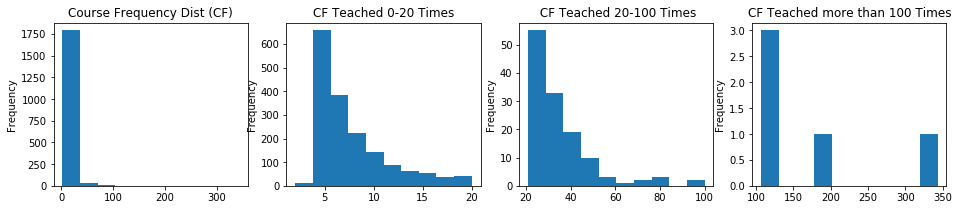

In [17]:
def plot_course_freq_dist(df):
    a = df.groupby(['num'])['dept'].count()#.values
    plt.figure(figsize=(16,3))
    plt.subplot(1,4,1);
    plot_histogram(a,'Course Frequency Dist (CF)')
    
    plt.subplot(1,4,2);
    plot_histogram(a[a <= 20],'CF Teached 0-20 Times')
    plt.subplot(1,4,3);
    plot_histogram(a[(a > 20) & (a <= 100)],' CF Teached 20-100 Times')
    plt.subplot(1,4,4);
    plot_histogram(a[(a > 100)], 'CF Teached more than 100 Times')
    plt.show()

plot_course_freq_dist(df_clean)

Let's see the same frequency but, with the same teacher.

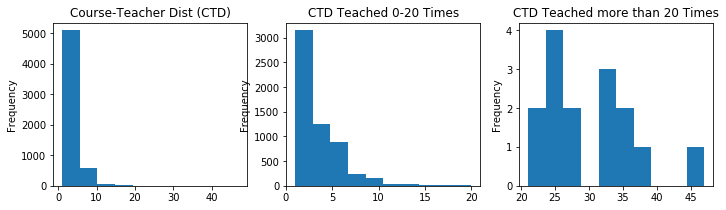

In [18]:
def plot_course_teacher_freq_dist(df):
    a = df.groupby(['num', 'prof'])['dept'].count()
    plt.figure(figsize=(16,3))

    plt.subplot(1,4,1);
    plot_histogram(a, 'Course-Teacher Dist (CTD)')
    plt.subplot(1,4,2);
    plot_histogram(a[a <= 20],'CTD Teached 0-20 Times')
    plt.subplot(1,4,3);
    plot_histogram(a[(a > 20)],'CTD Teached more than 20 Times')
    plt.show()
    
plot_course_teacher_freq_dist(df_clean)    

Finally, let's see what we are here for. What's the registration of students distribution.

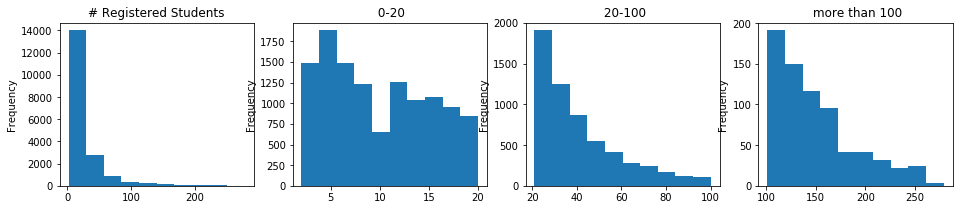

In [19]:
def plot_students_per_course_dist(df):
    a = df.students#.values
    plt.figure(figsize=(16,3))
    plt.subplot(1,4,1);
    plot_histogram(a,'# Registered Students')
    
    plt.subplot(1,4,2);
    plot_histogram(a[a <= 20],' 0-20')
    plt.subplot(1,4,3);
    plot_histogram(a[(a > 20) & (a <= 100)],' 20-100')
    plt.subplot(1,4,4);
    plot_histogram(a[(a > 100)], ' more than 100')
    plt.show()

plot_students_per_course_dist(df_clean)

<a id='visualitzations'></a>
# Visualizations

<a id='interesting'></a>
## Interesting Patterns

With data fetched from FCE website, we tried to look for relationships between different criteria, and filter out useful features for our training model.

In [20]:
def get_all_features(filename):
    data = pd.read_csv(filename)    
    data1 = data[['1_answers','1_clear_goals','1_course_name','1_course_rate','1_course_requirements',
                  '1_dept','1_feedback','1_hrs_week','1_level','1_num','1_prof_interest','1_respect',
                  '1_semester', '1_semester_int', '1_students', '1_subject_importance', '1_subject_matter',
                  '1_teaching_rate', '1_year']]
    data1.columns = [['answers','clear_goals','course_name','course_rate','course_requirements',
                      'dept','feedback','hrs_week','level','num','prof_interest','respect',
                      'semester', 'semester_int', 'students', 'subject_importance', 'subject_matter',
                      'teaching_rate', 'year']]
    
    data2 = data[['2_answers','2_clear_goals','2_course_name','2_course_rate','2_course_requirements',
                  '2_dept','2_feedback','2_hrs_week','2_level','2_num','2_prof_interest','2_respect',
                  '2_semester', '2_semester_int', '2_students', '2_subject_importance', '2_subject_matter',
                  '2_teaching_rate', '2_year']]
    data2.columns = [['answers','clear_goals','course_name','course_rate','course_requirements',
                      'dept','feedback','hrs_week','level','num','prof_interest','respect',
                      'semester', 'semester_int', 'students', 'subject_importance', 'subject_matter',
                      'teaching_rate', 'year']]
    
    data3 = data[['3_answers','3_clear_goals','3_course_name','3_course_rate','3_course_requirements',
                  '3_dept','3_feedback','3_hrs_week','3_level','3_num','3_prof_interest','3_respect',
                  '3_semester', '3_semester_int', '3_students', '3_subject_importance', '3_subject_matter',
                  '3_teaching_rate', '3_year']]
    data3.columns = [['answers','clear_goals','course_name','course_rate','course_requirements',
                    'dept','feedback','hrs_week','level','num','prof_interest','respect',
                    'semester', 'semester_int', 'students', 'subject_importance', 'subject_matter',
                    'teaching_rate', 'year']]
    
    data4 = data[['4_answers','4_clear_goals','4_course_name','4_course_rate','4_course_requirements',
                  '4_dept','4_feedback','4_hrs_week','4_level','4_num','4_prof_interest','4_respect',
                  '4_semester', '4_semester_int', '4_students', '4_subject_importance', '4_subject_matter',
                  '4_teaching_rate', '4_year']]
    data4.columns = [['answers','clear_goals','course_name','course_rate','course_requirements',
                      'dept','feedback','hrs_week','level','num','prof_interest','respect',
                      'semester', 'semester_int', 'students', 'subject_importance', 'subject_matter',
                      'teaching_rate', 'year']]
    
    frame = [data1, data2, data3, data4]
    res = pd.concat(frame)
    res = res.dropna(subset=['hrs_week'],inplace = False)
    return res

graph_data = get_all_features("data/features_5_years.csv")

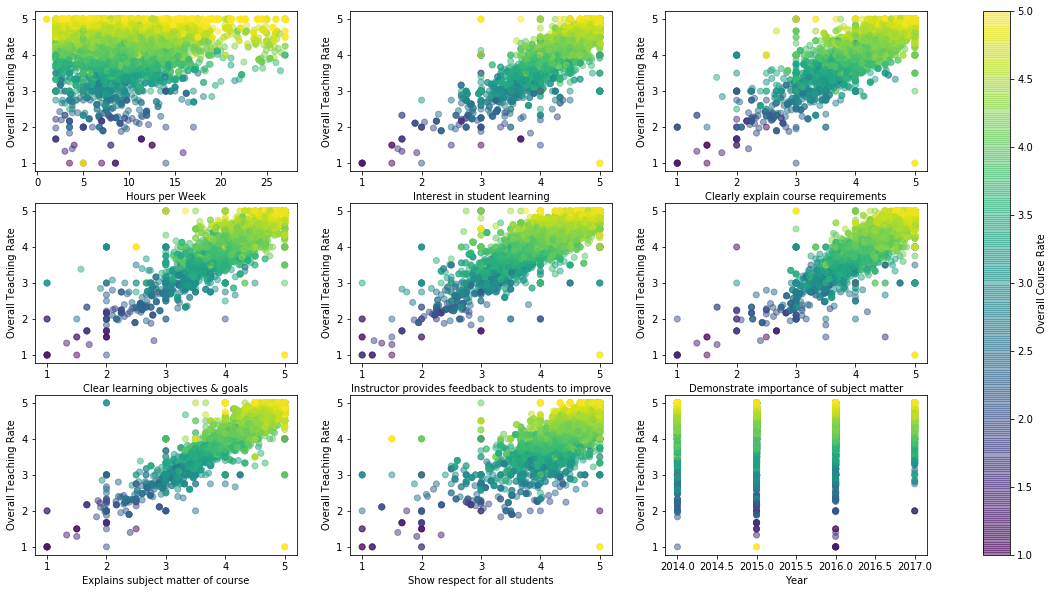

In [21]:
def plot_features(all_data):
    all_1 = all_data['prof_interest']
    all_2 = all_data['course_requirements']
    all_3 = all_data['clear_goals']
    all_4 = all_data['feedback']
    all_5 = all_data['subject_importance']
    all_6 = all_data['subject_matter']
    all_7 = all_data['respect']
    all_hrperwk = all_data['hrs_week']   
    all_teach_rate = all_data['teaching_rate']
    all_year = all_data['year']
    
    all_course_rate= all_data['course_rate']
    c = all_course_rate

    fig, axes = plt.subplots(3, 3, figsize=(20,10))
    plt0 = axes[0,0].scatter(all_hrperwk, all_teach_rate, c=c, alpha = 0.5)
    axes[0,0].set_xlabel('Hours per Week')
    axes[0,0].set_ylabel('Overall Teaching Rate')

    plt0 = axes[0,1].scatter(all_1, all_teach_rate, c=c, alpha = 0.5)
    axes[0,1].set_xlabel('Interest in student learning')
    axes[0,1].set_ylabel('Overall Teaching Rate')

    plt0 = axes[0,2].scatter(all_2, all_teach_rate, c=c, alpha = 0.5)
    axes[0,2].set_xlabel('Clearly explain course requirements')
    axes[0,2].set_ylabel('Overall Teaching Rate')

    plt0 = axes[1,0].scatter(all_3, all_teach_rate, c=c, alpha = 0.5)
    axes[1,0].set_xlabel('Clear learning objectives & goals')
    axes[1,0].set_ylabel('Overall Teaching Rate')


    plt0 = axes[1,1].scatter(all_4, all_teach_rate, c=c, alpha = 0.5)
    axes[1,1].set_xlabel('Instructor provides feedback to students to improve')
    axes[1,1].set_ylabel('Overall Teaching Rate')

    plt0 = axes[1,2].scatter(all_5, all_teach_rate, c=c, alpha = 0.5)
    axes[1,2].set_xlabel('Demonstrate importance of subject matter')
    axes[1,2].set_ylabel('Overall Teaching Rate')


    plt0 = axes[2,0].scatter(all_6, all_teach_rate, c=c, alpha = 0.5)
    axes[2,0].set_xlabel('Explains subject matter of course')
    axes[2,0].set_ylabel('Overall Teaching Rate')

    plt0 = axes[2,1].scatter(all_7, all_teach_rate, c=c, alpha = 0.5)
    axes[2,1].set_xlabel('Show respect for all students')
    axes[2,1].set_ylabel('Overall Teaching Rate')

    plt0 = axes[2,2].scatter(all_year, all_teach_rate, c=c, alpha = 0.5)
    axes[2,2].set_xlabel('Year')
    axes[2,2].set_ylabel('Overall Teaching Rate')

    cb = plt.colorbar(plt0,ax=axes)
    cb.set_label('Overall Course Rate')

    plt.show()


plot_features(graph_data)

Initially, we assume that the workloads of each courses will have a negative relation with the final course rate. However, as figure 1 shows, although all courses with low teaching and course rate have a relatively low workload, they are irrelevant with hours per week when the rates are over 4.0. 

As for the other 7 criteria, they are pretty much proportional to the overall teaching and course rate. However, their weights are different to the final score. Comparing Figure 7 and Figure 8, we can see that "Explains subject matter of course" is much more important than "Show respect for all students" as it shows a pattern with a higher slope and a more clear color transition.

<a id='trends'></a>
## Trends

Here we want to look into the trends of classes CMU provided and the of the IT industry and see whether they are connected.

<a id='trends_visualization'></a>
### Visualization of the top trending technical topics

First, we scrape data from Forbes twitter for the technology trends in the recent 5 years and store the trending topics in “csv” file. Then we process the data and sort it for the top trending technical topics.

In [22]:
import csv
from collections import Counter

forbes_reader = csv.reader(open("./data/tech_trends_forbes.csv", "r"), delimiter=",")
forbes_trends = list(forbes_reader)
forbes_trends = np.array(forbes_trends)

trends_list = []
for row in forbes_trends[1:]:
    for w in row[1:]:
        if w:
            tmp_list = w.split(",")
            trends_list.extend(tmp_list)

trends_counter = Counter(trends_list)
sorted_trends = trends_counter.most_common()

sorted_trends_list = []
for t in sorted_trends:
    sorted_trends_list.append(t[0])

tech_words_list = []
for w in sorted_trends_list:
    w = w.lower()
    tech_words_list.extend(w.split())

# get the set of the top trending tech words
tech_words_set = set(tech_words_list)

print(tech_words_list[:10])

['blockchain', 'vr', 'iot', 'intelligent', 'apps', 'intelligent', 'things', 'ar', 'adaptive', 'security']


Then we want to extract the top trending topic from the classes provided by CMU in recent years.

In [23]:
from rake_nltk import Metric, Rake
from nltk.corpus import stopwords

fce_reader = csv.reader(open("./data/table.csv", "r"), delimiter=",")
fce = list(fce_reader)
fce = np.array(fce)

with open('./data/courses_ids.json') as f:
    courses_ids = json.load(f)
    
#print(len(courses_ids))
course_num = len(courses_ids)
text = ""
for i in range(course_num):
    text += " "
    text += str(courses_ids[i]['n'])

# Uses stopwords for english from NLTK, and all puntuation characters.
stopWords = set(stopwords.words('english'))

# To use it with English supported by nltk.
r = Rake("english")

# If you want to provide your own set of stop words and punctuations to
r = Rake(stopwords=stopWords)

r.extract_keywords_from_text(text)

#ranked_words = r.get_ranked_phrases_with_scores() # To get keyword phrases ranked highest to lowest.
ranked_words = r.get_ranked_phrases() # To get keyword phrases ranked highest to lowest.

print(ranked_words[:3])


['experimentalists differential geometry mathematical studies analysis ii geographic information systems engineering run time malware detection behavioral decision making tissue engineering opera literature sustainable design synthesis prep guest experience', 'test class test class 2 test 3 test 4 test 4 test 5 research advanced digital design systems research using nsf probe experimental clusters test class', 'complex communication systems data warehousing mscf options 08705 msit ebiz round2 first year seminar software design formal methods ii relationships 101 choices']


In [24]:
class_terms = []

for w in ranked_words:
    w = w.lower()
    class_terms.extend(w.split(" "))

term_counter = Counter(class_terms)
sorted_terms = term_counter.most_common()
top_class_name_terms = []

for t in sorted_terms:
    if t[0] in tech_words_set:
        if t[0] == 'learning':
            top_class_name_terms.append('machine learning')
        elif t[0] != 'machine':
            top_class_name_terms.append(t[0])

print(top_class_name_terms[:10])

['systems', 'data', 'computing', 'advanced', 'machine learning', 'information', 'security', 'analytics', 'architecture', 'digital']


In order to present the top trending words more clearly, we use WordCloud to visualize the words extracted from the two sources.

-------- Class Tech Words --------


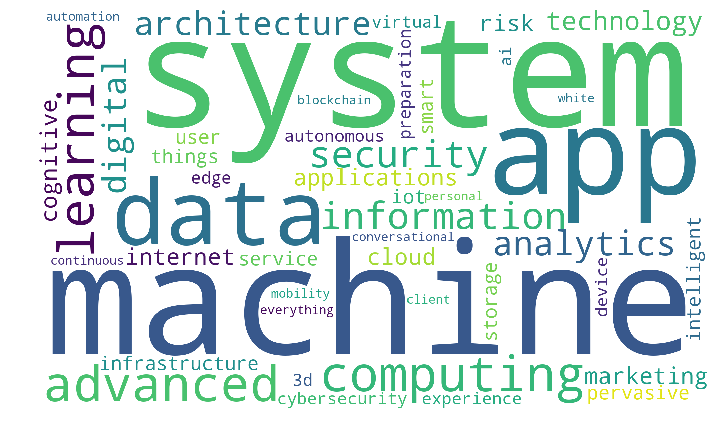

-------- Trending Tech Words --------


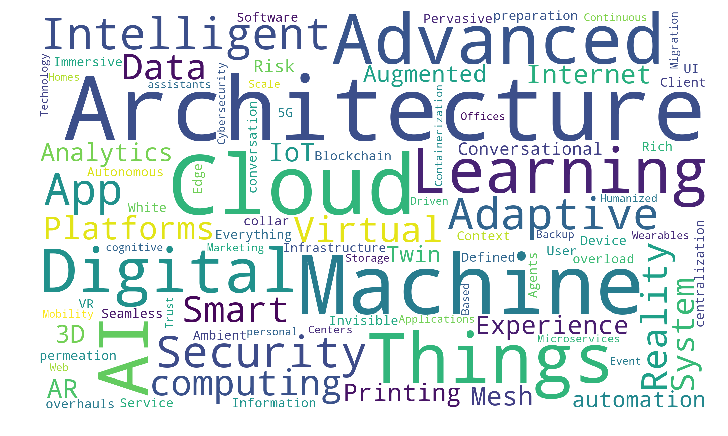

In [25]:
# import the word cloud generator and matploylib
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def draw_cloud(cleaned_data, fig_name, color = 'white', map_color = 'viridis'):
    words = ' '.join(cleaned_data)
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = color,
                      width = 2000, height = 1200, colormap = map_color).generate(words)
    plt.figure(1, figsize = (12, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    #plt.savefig(fig_name)
    plt.show()

# Plot the word clouds
print("-------- Class Tech Words --------")
draw_cloud(top_class_name_terms, 'classname_wordcloud')
print("-------- Trending Tech Words --------")
draw_cloud(sorted_trends_list, 'trends_wordcloud')

<a id='feature'></a>
# Feature Engineering

<a id='course_type'></a>
## Type of Courses

A type of feature we can use is to cluster our data, using distinct categories such as:

- Based on size of Registered Student
    - Courses with less than 10 Students
    - Courses with less than 20 Students
    - Courses with less than 30 Students
    - Courses with less than 50 Students
    - Courses with less than 100 Students
    - Courses with less than 300 Students
    - Courses with more than 300 Students
    
    
- Based on frequency
    - Courses that are offered Once a year
    - Courses that are offered Twice a year
    - Courses that are offered Three times a year
    
    
- Based on change in student registration
    - Courses that always have small change
    - Courses that have big change

<a id='size'></a>
### Size of Registered Student

In [26]:
def set_size_category(df, years=3, ranges=[10,20,30,50,100,300,1000]):
    df_new = pd.DataFrame()
    
    df_new['students_max'] = df['1_students']
    df_new['students_avg'] = 0
    for i in range(1,years-1):
        df_new['students_avg'] += df['%d_students' % i] 
        df_new['students_max'] = np.maximum(df_new['students_max'].values, df['%d_students' % i].values)
    
    df_new['students_avg'] = df_new['students_avg']/(years-1)
    
    def category(value):
        for i, val in enumerate(ranges):
            if value < val:
                return i
        return len(ranges)
        
    df['students_avg_category'] = df_new.students_avg.apply(category)
    df['students_max_category'] = df_new.students_max.apply(category)
    df['students_avg'] = df_new.students_avg
    df['students_max'] = df_new.students_max
    
    return df_new

set_size_category(df_join, years=5)    
df_join.groupby('students_max_category')[['0_num']].count()

,0_num
students_max_category,
0,431
1,661
2,411
3,516
4,495
5,515
6,119
7,2


<a id='frequency'></a>
### Frequency

In [27]:
def set_frequency(df, years=3):
    df_new = pd.DataFrame()
    
    def semester_one_hot_encoding(row):
        dic = dict(Fall=1, Summer=10, Spring=100)
        fall = False
        result = ['0']*3

        for i in range(years):
            if row['%d_semester_int'%i] == 9:# 'Fall':
                result[2] = '1'
                break
        for i in range(years):
            if row['%d_semester_int'%i] == 5:#'Summer':
                result[1] = '1'
                break
        for i in range(years):
            if row['%d_semester_int'%i] == 1:#'Spring':
                result[0] = '1'
                break

        return ''.join(result)

    df_new['frequency'] = df.apply(semester_one_hot_encoding, axis=1)
    df['frequency'] =  df_new.frequency
    return df_new

df = set_frequency(df_join, years=5)
df['dummy'] = 1
df.groupby('frequency').count()

,dummy
frequency,
001,418
100,384
101,2348


<a id='change'></a>
### Change in Students Registration 

In [28]:
def set_delta_students(df, years=3):
    df_new = pd.DataFrame()
    
    for i in range(1,years-1):
        df_new['delta_students_%d' % i] = (df['%d_students' % i] - df['%d_students' % (i+1)])/df['%d_students' % (i+1)]

    df_new['delta_students'] = 0
    for i in range(1,years-1):
        df_new['delta_students'] += df_new['delta_students_%d' % i].abs()
    
    def category(value):
        value = abs(value)
        if value == 0:
            return 0
        elif value <= 0.5:
            return 1
        elif value <= 1:
            return 2
        elif value <= 10:
            return 3
        elif value <= 100:
            return 4
        else:
            return 5
        
    df_new['delta_category'] = df_new.delta_students.apply(category)
    
    df['delta_students'] = df_new.delta_students
    df['delta_category'] = df_new.delta_category

    return df_new

df = set_delta_students(df_join, years=5)   
df_join.groupby('delta_category')[['0_num']].count()

,0_num
delta_category,
0,13
1,551
2,804
3,1715
4,66
5,1


<a id='importance'></a>
## Features Importance

Here we are plotting how the change in one feature alter the number of students registered

In [29]:
def check_delta(df, feature, years=3):
    df_new = pd.DataFrame()
    
    for i in range(1,years-1):
        dif = (df['%d_%s' % (i, feature)] - df['%d_%s' % (i+1, feature)])
        df_new['delta_%s_%d' % (feature, i)] =dif/df['%d_%s' % (i+1, feature)]

    df_new['delta_feature'] = 0
    for i in range(1,years-1):
        df_new['delta_feature'] += df_new['delta_%s_%d' % (feature, i)].abs()
    
    return df_new


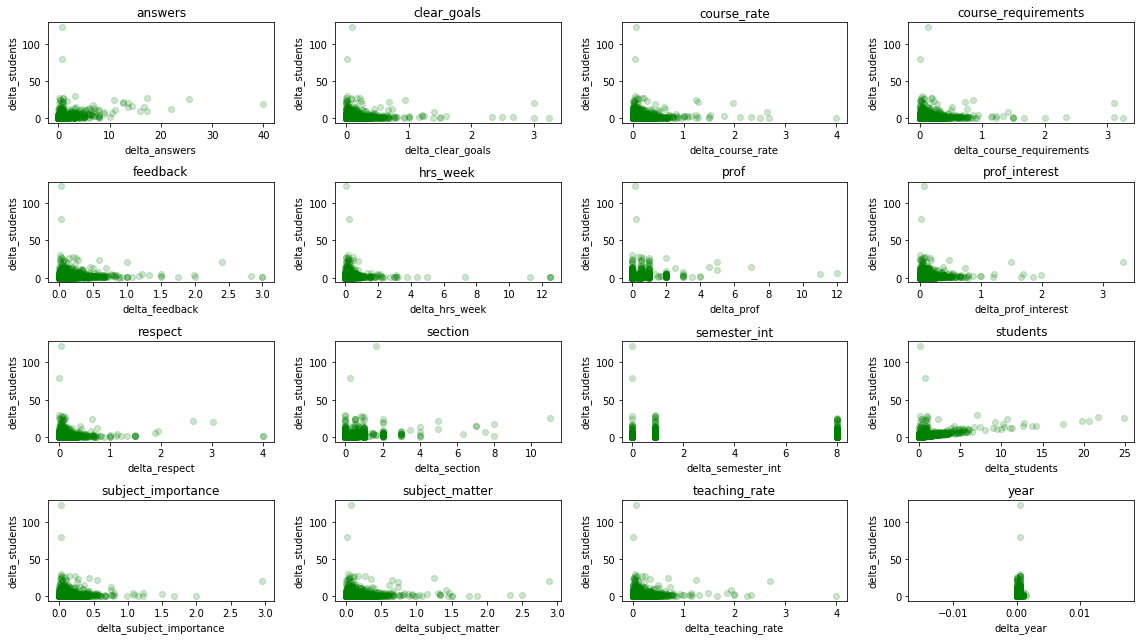

In [30]:
idx = 1
plt.figure(figsize=(16,9))

df = df_join
for i, col in enumerate(df_join.columns):
    if col[:2] != '1_' :
        continue

    col = col[2:]

    # Ignore string features
    if col  in {'dept', 'course_name', 'level', 'num', 'semester'}:
        continue

    df = check_delta(df_join, col)
    plt.subplot(4,4,idx)
    plt.scatter(df.delta_feature, df_join.delta_students, c="g", alpha=0.2,)
    plt.xlabel("delta_%s" % col)
    plt.ylabel("delta_students")
    plt.title(col)

    idx += 1
plt.tight_layout()
plt.show()

Here we can see that the previous change in students is the only feature which has a strong correlation with the future change in students.

The previous change in other features does not show such a strong relation.

<a id='prediction'></a>
# Prediction

For the prediction, we will first encode our string features to be used using LabelEncoder, split them into training and testing sets for validation, train and predict the results using scikit-learn library.

In [31]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

Firstly, let's encode transform our string features into integers

In [32]:
def encode(df, keys_to_encode=[], remove=[], verbose=True):
    le = {}
    data = df.copy(deep=True)
    
    for key, values in remove:
        for value in values:
            data = data[df[key] != value]
    
    for key in keys_to_encode:
        le[key] = LabelEncoder()
        le[key].fit(data[key].values)
        data[key] = le[key].transform(data[key].values)    

    if verbose:
        for key in keys_to_encode:
            print(key, le[key].classes_)

    return data, le 

Secondly, let's split our data into a training and a testing set

In [33]:
def split(X,y,n_splits=10, standardized_flag=True, verbose=False):
    y = y.values
    if standardized_flag:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    skf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    skf.get_n_splits(X)
    
    scores = []
    
    max_score = 0
    max_clf = None
    max_data = None
    max_labels = None
    max_predict = None
    
    for train_index, test_index in skf.split(X, y):
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        return train_x, test_x, train_y, test_y
#     return np.mean(scores)#, max_score, max_clf, max_data, max_label, max_predict

Thirdly, we build the training and predicting function to take the data and output the labels.

In [34]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

def train(X,Y,standardized_flag=True,cols=[], verbose=True):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    train_x, test_x, train_y, test_y = split(X,Y, standardized_flag=standardized_flag)
    # Train the model using the training sets
    regr.fit(train_x, train_y)

    # Make predictions using the testing set
    pred_y = regr.predict(test_x)

    # The coefficients
    if verbose and COEFFICIENTS:
        print('Coefficients:')
        for a,b in  sorted(list(zip(cols,regr.coef_)), key=lambda x:x[1]):
            print('%s\t\t%.2f' % (a,b))

    mse = mean_squared_error(test_y, pred_y) 
    rmse = mse ** 0.5

    if verbose:
        # The mean squared error
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % rmse)
        
    return regr, mse, rmse


def tree_train(X,Y,standardized_flag=True,cols=[], verbose=True):
    train_x, test_x, train_y, test_y = split(X,Y, standardized_flag=standardized_flag)
    
    # Create the dataset
    rng = np.random.RandomState(1)
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=4)

    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                              n_estimators=300, random_state=rng)

    regr_1.fit(train_x, train_y)
    regr_2.fit(train_x, train_y)

    # Predict
    pred_y_1 = regr_1.predict(test_x)
    pred_y = regr_2.predict(test_x)

    mse = mean_squared_error(test_y, pred_y_1) 
    rmse = mse ** 0.5
    
    if verbose:
        print("Without Boosting")
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % rmse)
    
    mse = mean_squared_error(test_y, pred_y) 
    rmse = mse ** 0.5

    if verbose:
        # The mean squared error
        print("\nWith Boosting")        
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % rmse)
        
    return regr_2, mse, rmse

def grouped_train(df, feature='dummy', verbose=True, tree=True):
    df['dummy'] = 1

    total_n = 0
    mse_total = 0
    for name, group in df.groupby(feature):
        N = group.shape[0]
        if verbose:
            print('~'*60)
            print(feature, name, ' Size: %d ' % N)

        if (group.shape[0] < 10):
            if verbose:
                print('skipped')
                print(group[cols])
            continue

        total_n += N
        # Split Data in Features and Label
        X, Y = group, group.pop('0_students')

        X = X.fillna(0)
        cols = X.columns
        if tree:
            _, mse, rmse = tree_train(X.values,Y,standardized_flag=False, cols=cols, verbose=verbose)
        else:
            _, mse, rmse = train(X.values,Y,standardized_flag=False, cols=cols, verbose=verbose)
        mse_total += mse*N
    
    if verbose:
        print('\nTOTAL RMSE', (mse_total/total_n)**0.5)
    return (mse_total/total_n)**0.5
    

<a id='implementation'></a>
# Implementation

In this implementation section, we want to use all the previous work, to finally predict the course rate. Let's start using all the features and Linear Regression

In [35]:
# Disable Pringting Coefficients
COEFFICIENTS=False

df = df_join.copy(deep=True)

grouped_train(df, feature='dummy', verbose=True, tree=False)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
dummy 1  Size: 3150 
MSE: 1170.24
RMSE: 34.21

TOTAL RMSE 34.208832221


34.208832221049555

What about using trees?

In [36]:
# Before Training
df = df_join.copy(deep=True)

grouped_train(df, feature='dummy', verbose=True, tree=True)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
dummy 1  Size: 3150 
Without Boosting
MSE: 1564.83
RMSE: 39.56

With Boosting
MSE: 2618.05
RMSE: 51.17

TOTAL RMSE 51.1668826913


51.166882691309887

We tried different combinations of features, as well as different way of clustering the dataset.

We obtained our lowest RMSE: Using only the previous number of students in the different years, as well as the 'students_max_category' as our clustering factor.

So let's see those results.

In [37]:
# Training
df = df_join.copy(deep=True)

# Exclude Summers
features = ['students', 'level']

feats = ['%d_%s' % (y,f) for f in features for y in range(1,YEARS)]

# frequency
df = df[feats + ['0_students', '0_num', '0_semester_int', '0_year', 
                 'students_avg_category', 'students_avg',
                 'students_max_category', 'students_max', 
                 'frequency', 'delta_students', 'delta_category']]

# -- Cluster --
df['split'] = 0

# 1- Courses <= 100 Students
df.loc[df.students_max_category.values <= 4,'split'] = 100
# 2- Courses 100 < X <= 300  Students
df.loc[df.students_max_category == 5, 'split'] = 300
# 3- Courses > 300  Students
df.loc[df.students_max_category > 5, 'split'] = 1000
# 3.5- Divide Courses > 300  Students 
#      -> Courses which are first year     ex. XX-1XX
#      -> Courses which are not first year ex. XX-[2-9]XX
big_courses = df.loc[df.split == 1000].copy()
tmp = encoders['num'].inverse_transform(list(map(int,big_courses['0_num'].values)))
big_courses['num'] = tmp
tmp  = 1000 + (big_courses.num.str[-3] == '1')*1
df.loc[df.split == 1000, 'split'] = tmp 

grouped_train(df, feature='split', verbose=True, tree=False)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 100  Size: 2514 
MSE: 147.74
RMSE: 12.15
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 300  Size: 515 
MSE: 2541.91
RMSE: 50.42
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 1000  Size: 58 
MSE: 16918.19
RMSE: 130.07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 1001  Size: 63 
MSE: 8672.45
RMSE: 93.13

TOTAL RMSE 31.9132011206


31.913201120567862

<a id='result'></a>
# Results

We have tried many ways to extract the right kinds and amount of features as well as ways to train and validate for our prediction. The methods with tje most impact and according results are shown as below.

#### Try #1 - Naive Approach no changes

RMSE: 135.33
    
#### Try #2 # Use 5 years instead of 3

RMSE: 96.95
    
#### Try #3 # Encode string parameters

RMSE: 95.35

#### Try #4 - Fix: KFold instead of StratifiedKFold

RMSE: 50.21

#### Try #6 - Include some features from the current year. (semester, dept, etc.)

RMSE: 46.14

#### Try #7 - Remove summer courses

RMSE: 32.13

#### Try #9 - Split Dataset and Remove features
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
split 100  Size: 2514 
RMSE: 12.15
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
split 300  Size: 515 
RMSE: 50.42
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
split 1000  Size: 58 
RMSE: 130.07
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
split 1001  Size: 63 
RMSE: 93.13

TOTAL RMSE 31.9132011206

<a id='conclusion'></a>
# Conclusion

In conclusion, we to predict the number of students who want to get in a course for the next semester, to help the registration office with quota allocation. 

We have presented our work to scrape the course data from FCE website, pre-process, group and join the data for training usage, for which the properties and distributions are shown in the Analyzing section. Moreover, we visualized some of the features in the dataset, trying to find some corrections in the criterias and finding the features we should use. We also analyzed the current trends of technology and included the popularity of topics as a weighted feature. With these data, we tried many ways to extract the most important features and build a model for the best results. Finally, we can achieve a RMSE that less than 15% for classe that has less than 100 students, for which we have the most and adequate data for training (2514 records). We believe that, if we can collect more data for classes with largers size, this model can work well for them too.